<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
## Imports
import nibabel as nb
import numpy as np
import h5py
import copy
import time
import os
import subprocess
import glob
import seaborn as sns
import pandas as pd
import scipy as sp
from scipy.stats import gamma
from scipy.io import loadmat, savemat
from nilearn.image import resample_to_img, resample_img, math_img
import sys


import cortex

from joblib import Parallel, delayed

import matplotlib.pyplot as plt
import matplotlib.colors as colors


from prfpy.rf import *
from prfpy.timecourse import *
from prfpy.stimulus import PRFStimulus2D
from prfpy.model import Iso2DGaussianModel, CSS_Iso2DGaussianModel
from prfpy.fit import Iso2DGaussianFitter, CSS_Iso2DGaussianFitter

%matplotlib inline

/mnt/export/data1/projects/MicroFunc/Jurjen/programs/packages/prfpy/prfpy/model.py:5: FutureWarning: 

 | Starting with Nilearn 0.7.0, all Nistats functionality has been incorporated into Nilearn's stats & reporting modules.
 | Nistats package will no longer be updated or maintained.

  from nistats.hemodynamic_models import spm_hrf, spm_time_derivative, spm_dispersion_derivative


In [2]:
# prf_dir = '/scratch/2020/visual/cerebellum_prf/derivatives/prf/'
# pybest_dir = '/scratch/2020/visual/cerebellum_prf/derivatives/pybest/'
# fs_dir = '/tank/shared/2020/line/data/downloads/freesurfer'

subject = 'sub-005'
ses = 'ses-1'
task = '2R'

place = "spin"

if place == "win":
    base = 'D:\\FSL\\shared\\spinoza'
    sep = "\\"
elif place == "lin":
    sep = "/"
    base = '/mnt/hgfs/shared/spinoza'
elif place == "spin":
    sep = "/"
    base = '/data1/projects/MicroFunc/Jurjen'

proj = os.path.join(base, 'projects', 'hemifield')
prog = os.path.join(base, 'programs', 'linescanning')

from linescanning.utils import get_prfdesign
from linescanning.glm import *

fs_dir = os.path.join(proj, 'derivatives', 'freesurfer')
ctx_dir = os.path.join(proj, 'derivatives', 'pycortex')
prf_dir = os.path.join(proj, 'derivatives', 'prf')
pybest_dir = os.path.join(proj, 'derivatives', 'pybest')
source_dir = os.path.join(proj, 'sourcedata')

In [3]:
if os.path.isfile(os.path.join(prf_dir, subject, 'vis_design.mat')):
    print("Design matrix: {mat}".format(mat=os.path.join(prf_dir, subject, 'vis_design.mat')))   
    design_matrix = loadmat(os.path.join(prf_dir, subject, 'vis_design.mat'))
else:
    print("Creating new design matrix")
    path_png = os.path.join(proj, 'sourcedata', subject, 'ses-1', f'{subject}_ses-1_task-{task}_run-2_Logs', f'{subject}_ses-1_task-{task}_run-2_Screenshots')
    
    if os.path.isdir(path_png):
        
        dm = get_prfdesign(path_png, n_pix=54, dm_edges_clipping=[6,1,0,1])

        if os.path.isdir(os.path.join(prf_dir, subject)):
            pass
        else:
            os.mkdir(os.path.join(prf_dir, subject))

        savemat(os.path.join(prf_dir, subject, 'vis_design.mat'), {"stim": dm})
        design_matrix = loadmat(os.path.join(prf_dir, subject, 'vis_design.mat'))

    else:
        
        print("Could not find path to screenshots")


Design matrix: /data1/projects/MicroFunc/Jurjen/projects/hemifield/derivatives/prf/sub-005/vis_design.mat


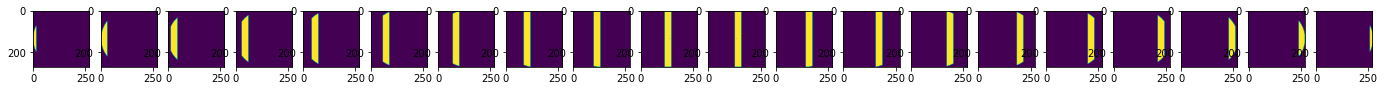

In [4]:
f, ss = plt.subplots(1,20,figsize=(24,3))
# ss[0].imshow(design_matrix['stim'].T[20])

for x in range(15,35):
    ss[x-15].imshow(design_matrix['stim'][...,x])

In [5]:
tps, xdim, ydim = design_matrix['stim'].T.shape
print(tps, xdim, ydim)
print(design_matrix['stim'].shape)
# print(design_matrix['stim'].transpose(1,0,2).shape)

225 270 270
(270, 270, 225)


In [6]:
# f, ss = plt.subplots(1,20,figsize=(24,3))
# # ss[0].imshow(design_matrix['stim'].T[20])

# lower_border = (xdim-ydim)//2

# new_dm = np.zeros((xdim, xdim, tps))
# new_dm[:,lower_border:lower_border+ydim,:] = design_matrix['stim'].transpose((1,0,2))

# for x in range(15,35):
#     ss[x-15].imshow(new_dm[...,x])

# # savemat(os.path.join(prf_dir, subject, 'new_design.mat'), {"stim": new_dm})

# print(new_dm.shape)

In [7]:
# good_runs = np.arange(13,25) # sub-001
# good_runs = np.arange(1,7) # sub-004
good_runs = np.arange(1,9) # sub-005

prf_tc_data = []
for gr in good_runs:
    prf_tc_data.append(np.hstack([
        np.load(os.path.join(pybest_dir, subject, f'{ses}', 'denoising', f'{subject}_{ses}_task-{task}_run-{str(gr)}_space-fsnative_hemi-{hemi}_desc-denoised_bold.npy'))
    for hemi in ['L', 'R']]))
m_prf_tc_data = np.median(np.array(prf_tc_data), 0)

# vertices per hemi
n_verts_per_hemi = [np.load(os.path.join(pybest_dir, subject, f'{ses}', 'denoising', f'{subject}_{ses}_task-{task}_run-{str(gr)}_space-fsnative_hemi-{hemi}_desc-denoised_bold.npy')).shape[-1] for hemi in ['L', 'R']]
print(n_verts_per_hemi)

[308624, 308600]


In [16]:
prf_stim = PRFStimulus2D(screen_size_cm=70, 
                         screen_distance_cm=225, 
                         design_matrix=design_matrix['stim'], 
                         TR=1.5)

grid_nr = 20
max_ecc_size = 15
sizes, eccs, polars = max_ecc_size * np.linspace(0.125,1,grid_nr)**2, \
                    max_ecc_size * np.linspace(0.05,1,grid_nr)**2, \
                        np.linspace(0, 2*np.pi, grid_nr, endpoint=False)

gg = Iso2DGaussianModel(stimulus=prf_stim,
                        filter_predictions=False,
                        filter_type='sg',
                        filter_params={'window_length':300, 
                                       'polyorder':1})

gg.create_grid_predictions(ecc_grid=eccs,
                 polar_grid=polars,
                 size_grid=sizes)

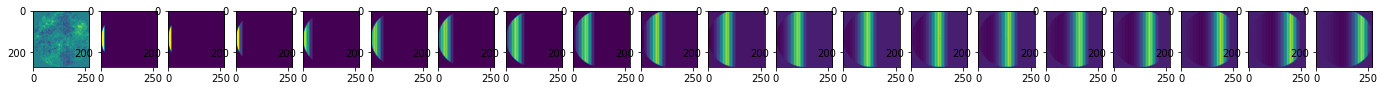

In [53]:
f, ss = plt.subplots(1,20,figsize=(24,3))
# ss[0].imshow(design_matrix['stim'].T[20])

for x in range(15,35):
    ss[x-15].imshow(prf_stim.convolved_design_matrix[...,x])

In [52]:
prf_stim.convolved_design_matrix.shape

(270, 270, 225)

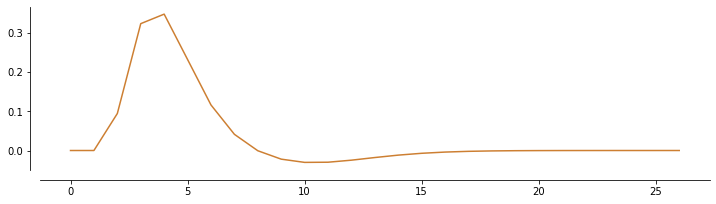

In [15]:
plot_array(gg.hrf[0])

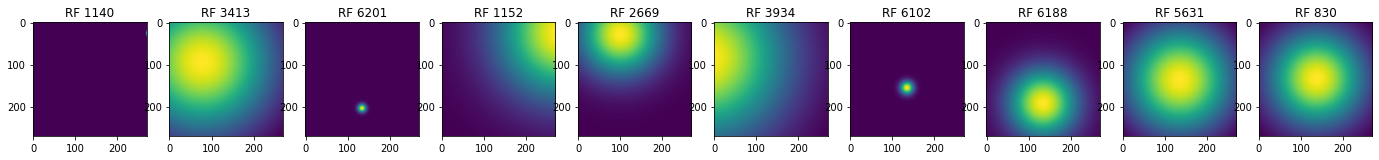

In [54]:
np.random.seed(2021)
f, ss = plt.subplots(1,10,figsize=(24,3))

rfs = np.random.choice(8000, 10)
for id,rf in enumerate(rfs):
    ss[id].imshow(gg.grid_rfs[int(rf),:,:])
    ss[id].set_title(f"RF {rf}")

In [59]:
gf.data.shape

(617224, 225)

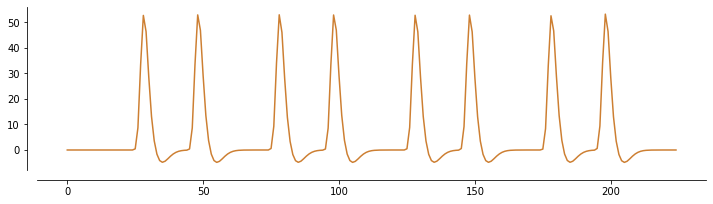

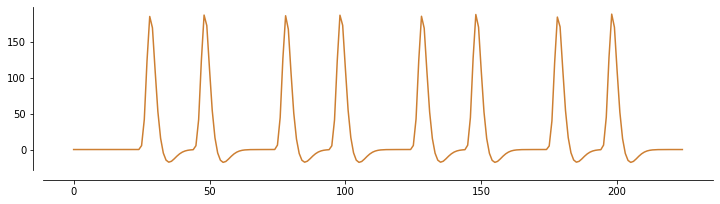

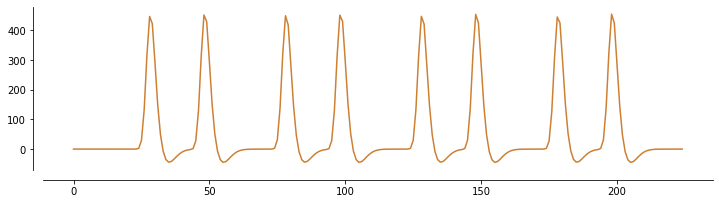

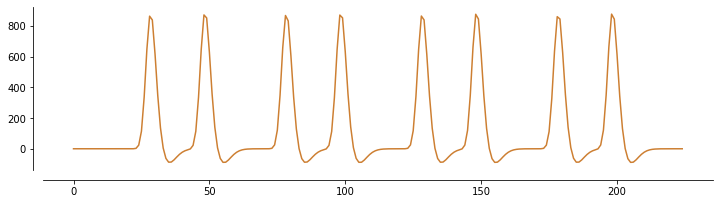

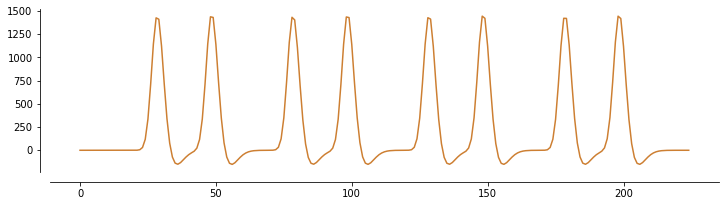

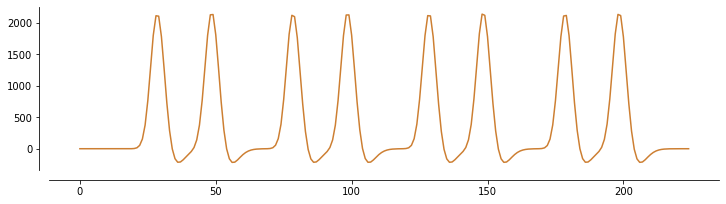

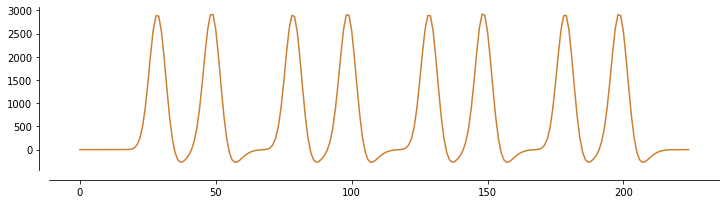

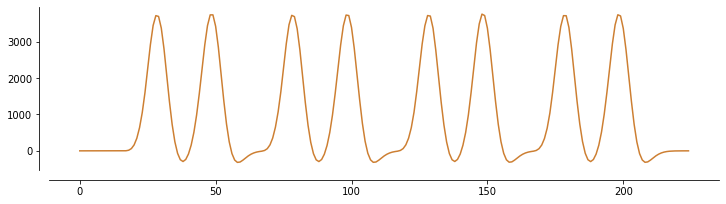

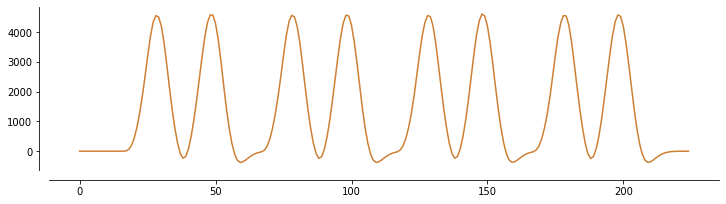

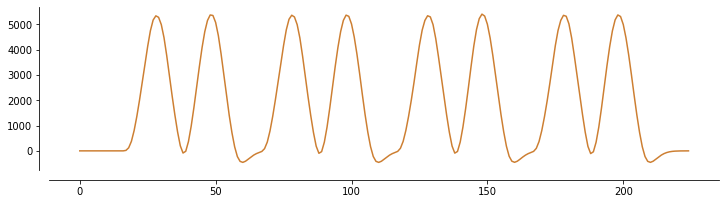

In [56]:
for id,rf in enumerate(rfs):
    plot_array(gg.predictions[id,:])

In [40]:
gf = Iso2DGaussianFitter(data=m_prf_tc_data.T, model=gg, n_jobs=30, fit_css=False)

In [44]:
gf.grid_fit(ecc_grid=eccs,
            polar_grid=polars,
            size_grid=sizes, 
            pos_prfs_only=False)

In [60]:
gf.__dict__

{'data': array([[ 0.576, -0.077,  0.184, ..., -0.568, -0.794, -0.137],
        [ 0.37 , -0.072,  0.235, ..., -0.489, -0.859, -0.083],
        [ 0.168,  0.16 ,  0.204, ..., -0.25 , -0.216,  0.184],
        ...,
        [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ]],
       dtype=float32),
 'model': <prfpy.model.Iso2DGaussianModel at 0x7f85665090b8>,
 'n_jobs': 30,
 'fit_hrf': False,
 'fit_css': False,
 'n_units': 617224,
 'n_timepoints': 225,
 'data_var': array([0.597, 0.573, 0.554, ..., 0.   , 0.   , 0.   ], dtype=float32),
 'gridsearch_r2': array([0.682, 0.681, 0.678, ...,   nan,   nan,   nan], dtype=float32),
 'best_fitting_baseline': array([-0.418, -0.391, -0.397, ...,  0.   ,  0.   ,  0.   ], dtype=float32),
 'best_fitting_beta': array([0.002, 0.001, 0.001, ..., 0.   , 0.   , 0.   ], dtype=float32),
 'gridsearch_params': array([[  7.957, -10.952,   4

fit for vox 5788 = 0.537524402141571


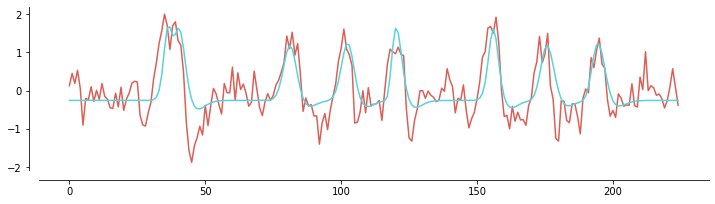

In [83]:
vox = 5788
params = gf.gridsearch_params[vox,:]
print(f"fit for vox {vox} = {params[-1]}")
data = gf.data[vox,:]
pred = gg.return_prediction(*params[:-1])[0]
plot_array([data,pred])

In [44]:
prf_params = gf.gridsearch_params
np.save(os.path.join(prf_dir, subject, f'{subject}_desc-prf_params.npy'), prf_params)
print(prf_params.shape)

(314535, 6)


/home/heij/.local/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/heij/.local/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


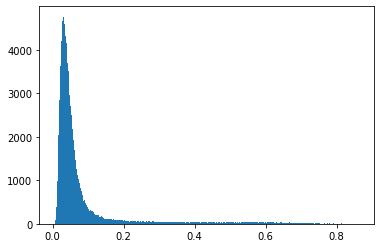

In [28]:
plt.hist(gf.gridsearch_params[:,-1], bins=1000);


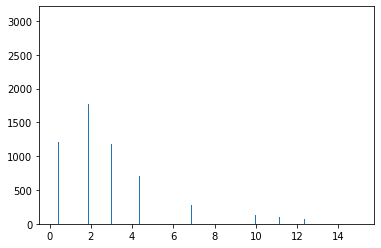

In [29]:
plt.hist(gf.gridsearch_params[:,2], weights=gf.gridsearch_params[:,-1], bins=1000);

In [44]:
r2_map = cortex.Vertex(gf.gridsearch_params[:,-1], subject=cx_subject, cmap="inferno")

l_V1_label, r_V1_label = [nb.freesurfer.io.read_label(os.path.join(freesurfer_subject_dir, fs_subject, 'label', f'{hemi}.V1_exvivo.thresh.label'), 
                                                      read_scalars=False) 
                          for hemi in ['lh','rh']]
l_V1_bin = np.zeros(n_verts_per_hemi[0], dtype=bool)
l_V1_bin[l_V1_label] = True
r_V1_bin = np.zeros(n_verts_per_hemi[1], dtype=bool)
r_V1_bin[r_V1_label] = True

whole_V1_mask = np.concatenate((l_V1_bin, r_V1_bin))
whole_V1_mask_v = cortex.Vertex(np.nan_to_num(whole_V1_mask).astype(int), subject=cx_subject, cmap='magma', vmin=-0.5)

In [52]:
ecc = np.sqrt(gf.gridsearch_params[:,0]**2+gf.gridsearch_params[:,1]**2)
ecc_v = cortex.Vertex2D(
                ecc, 
                gf.gridsearch_params[:,-1], 
                vmin=0, vmax=12, vmin2=0.05, vmax2=0.4, subject=cx_subject, cmap='spectral_alpha') # , vmin=0, vmax=0.5

In [73]:
polar = np.angle(gf.gridsearch_params[:,0]+gf.gridsearch_params[:,1]*1j)

polar_v = cortex.Vertex2D(
                polar, 
                gf.gridsearch_params[:,-1], 
                vmin=-np.pi, vmax=np.pi, vmin2=0.05, vmax2=0.4, subject=cx_subject, cmap='hsv_alpha')

In [74]:
joint_mask = (ecc < 5) * (gf.gridsearch_params[:,-1] > 0.4) * (whole_V1_mask)

joint_mask_v = cortex.Vertex(np.nan_to_num(joint_mask).astype(int), subject=cx_subject, cmap='magma', vmin=0.5)

/tank/tkn219/software/anaconda3/envs/cf_hcp/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


Stopping server


In [75]:
cortex.webshow({'polar': polar_v, 'joint_mask_v': joint_mask_v}, 
               port=12001, recache=False, open_browser=False, autoclose=True, overlays_visible=None, labels_visible=None, )

Started server on port 12001


<WebApp(Thread-11, started 46914087200512)>

Stopping server


(array([18784., 29864., 26280., 25363., 38244., 21073., 34848., 58515.,
        28372., 20932.]),
 array([-2.82743339, -2.23053078, -1.63362818, -1.03672558, -0.43982297,
         0.15707963,  0.75398224,  1.35088484,  1.94778745,  2.54469005,
         3.14159265]),
 <a list of 10 Patch objects>)

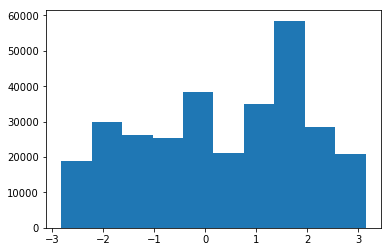

In [72]:
plt.hist(polar)